# HW 1: Deep learning
mail : jean-christophe.corvisier@eleves.enpc.fr

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]



Using TensorFlow backend.


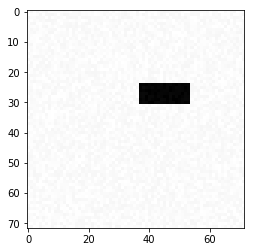

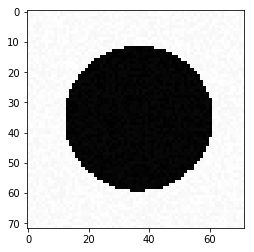

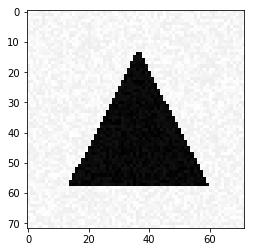

In [2]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.figure()
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.figure()
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [3]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]


In [4]:
#Testing the generation of datas
[X, Y] = generate_dataset_classification(10)
print("labels", Y)
print("array data", len(X[0]))
print(Y[1])

Creating data:
0
labels [1. 1. 2. 1. 1. 1. 1. 1. 2. 0.]
array data 5184
1.0


## Question 3) : Linear Model
To build a linear model, we just use a layer, with 3 outputs and a softmax activation,
our input is a vector of 5184 features. We train on 1000 instances, with 100 epochs

In [5]:
from keras.models import Sequential

In [6]:
model = Sequential()
from keras.layers import Dense, Activation
#three classes
model.add(Dense(3, activation='softmax', input_shape=(5184,)))

In [7]:
#stochastic gradient descent
from keras.optimizers import SGD
from keras.optimizers import Adam
sgd = SGD(lr=0.001,
decay=1e-6, momentum=0.9,
nesterov=True)
model.compile(loss='categorical_crossentropy',
optimizer=sgd)
[X_train, Y_train] = generate_dataset_classification(1000)
Y_train = np_utils.to_categorical(Y_train, 3)
model.fit(X_train, Y_train, epochs=100,batch_size=32)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
Epoch 1/100
1000/1000 [==============================] - 0s 247us/step - loss: 0.7131
Epoch 2/100
1000/1000 [==============================] - 0s 131us/step - loss: 0.2715
Epoch 3/100
1000/1000 [==============================] - 0s 122us/step - loss: 0.1945
Epoch 4/100
1000/1000 [==============================] - 0s 116us/step - loss: 0.1499
Epoch 5/100
1000/1000 [==============================] - 0s 100us/step - loss: 0.1323
Epoch 6/100
1000/1000 [==============================] - 0s 103us/step - loss: 0.1113
Epoch 7/100
1000/1000 [==============================] - 0s 97us/step - loss: 0.

1000/1000 [==============================] - 0s 100us/step - loss: 0.0077
Epoch 91/100
1000/1000 [==============================] - 0s 100us/step - loss: 0.0076
Epoch 92/100
1000/1000 [==============================] - 0s 100us/step - loss: 0.0075
Epoch 93/100
1000/1000 [==============================] - 0s 100us/step - loss: 0.0075
Epoch 94/100
1000/1000 [==============================] - 0s 116us/step - loss: 0.0074
Epoch 95/100
1000/1000 [==============================] - 0s 116us/step - loss: 0.0072
Epoch 96/100
1000/1000 [==============================] - 0s 116us/step - loss: 0.0072
Epoch 97/100
1000/1000 [==============================] - 0s 116us/step - loss: 0.0072
Epoch 98/100
1000/1000 [==============================] - 0s 107us/step - loss: 0.0072
Epoch 99/100
1000/1000 [==============================] - 0s 116us/step - loss: 0.0070
Epoch 100/100
1000/1000 [==============================] - 0s 131us/step - loss: 0.0069


In [8]:
#testing our model with SDG optimizer
score = 0
for j in range(100): 
    X_test = generate_a_disk()
    X_test = X_test.reshape(1, X_test.shape[0])
    array_res = model.predict(X_test)
    if array_res[0,1] == 1:
        score += 1
print("score on 100 tests is", score / 100.0)

score on 100 tests is 1.0


In [9]:
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad= False)
model.compile(loss='mean_squared_error',
optimizer = adam)
[X_train, Y_train] = generate_dataset_classification(1000)
Y_train = np_utils.to_categorical(Y_train, 3)
model.fit(X_train, Y_train, epochs=100, batch_size=32)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
Epoch 1/100
1000/1000 [==============================] - 0s 254us/step - loss: 2.1853e-04
Epoch 2/100
1000/1000 [==============================] - 0s 131us/step - loss: 3.8051e-04
Epoch 3/100
1000/1000 [==============================] - 0s 131us/step - loss: 1.4593e-04
Epoch 4/100
1000/1000 [==============================] - 0s 100us/step - loss: 1.2869e-04
Epoch 5/100
1000/1000 [==============================] - 0s 102us/step - loss: 1.2576e-04
Epoch 6/100
1000/1000 [==============================] - 0s 98us/step - loss: 1.2612e-04
Epoch 7/100
1000/1000 [==============================] - 

1000/1000 [==============================] - 0s 100us/step - loss: 2.7422e-05
Epoch 87/100
1000/1000 [==============================] - 0s 100us/step - loss: 2.3820e-05
Epoch 88/100
1000/1000 [==============================] - 0s 100us/step - loss: 2.4946e-05
Epoch 89/100
1000/1000 [==============================] - 0s 100us/step - loss: 2.2765e-05
Epoch 90/100
1000/1000 [==============================] - 0s 100us/step - loss: 2.5341e-05
Epoch 91/100
1000/1000 [==============================] - 0s 102us/step - loss: 2.3685e-05
Epoch 92/100
1000/1000 [==============================] - 0s 98us/step - loss: 2.1936e-05
Epoch 93/100
1000/1000 [==============================] - 0s 116us/step - loss: 2.2981e-05
Epoch 94/100
1000/1000 [==============================] - 0s 100us/step - loss: 2.3998e-05
Epoch 95/100
1000/1000 [==============================] - 0s 100us/step - loss: 2.7421e-05
Epoch 96/100
1000/1000 [==============================] - 0s 100us/step - loss: 2.3245e-05
Epoch 97/100


In [10]:
#testing our model with Adam optimizer
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

In [11]:
#testing our model with SDG optimizer
score = 0
for j in range(100): 
    X_test = generate_a_disk()
    X_test = X_test.reshape(1, X_test.shape[0])
    array_res = model.predict(X_test)
    if array_res[0,1] == 1:
        score += 1
print("score on 100 tests is", score / 100.0)

score on 100 tests is 1.0


## Observations
As we can see, we can quickly get a very good classifier (at least for what we have tested it, e.g the recognition of disks). With the two differents optimizer (SGD and Adams), we achieve a perfect score on 100 testing disks. But the Adams stepper seems better than the SDG on training, as we have a loss at the 100th epoch of 1e-5 for Adams optimizer, and 0.0069 for SDG.

## Question 4) :Visualisation of the weights

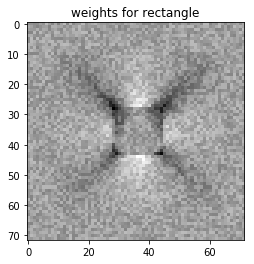

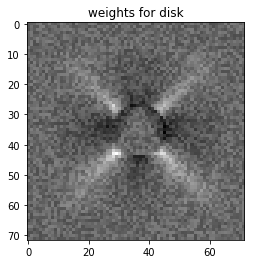

<Figure size 432x288 with 0 Axes>

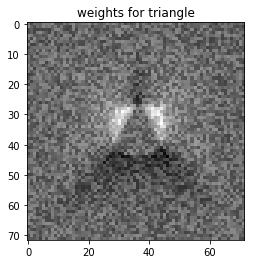

In [12]:
weights = model.get_weights()
weights_interesting = weights[0]
w_rectangle = weights_interesting[::,0]
w_disk = weights_interesting[::,1]
w_triangle = weights_interesting[::,2]

im_rectangle = w_rectangle.reshape((1,5184))
im_disk = w_disk.reshape((1,5184))
im_triangle = w_triangle.reshape((1,5184))

plt.figure()
plt.title("weights for rectangle")
plt.imshow(im_rectangle.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

plt.figure()
plt.title("weights for disk")
plt.imshow(im_disk.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

plt.figure()
plt.figure()
plt.title("weights for triangle")
plt.imshow(im_triangle.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

## Observations
As we can see here, we can recognize the form of the different shapes we are trying to learn in the matrix of the weights: the neural network clearly focus on the interesting features of the inputs.

## Question 5) :
## linear classifier
We create a single layer, with the desired outputs numbers (3 here), the input shape (flat vector of 5184 elements here) and an softmax activation. We use 300 instances with 100 epochs.

In [13]:
#three classes
mode = Sequential()
model.add(Dense(3, activation='softmax', input_shape=(5184,)))

In [14]:
sgd = SGD(lr=0.001,
decay=1e-6, momentum=0.9,
nesterov=True)
model.compile(loss='categorical_crossentropy',
optimizer=sgd, metrics=["accuracy"])
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
Y_train = np_utils.to_categorical(Y_train, 3)
model.fit(X_train, Y_train, epochs=100,batch_size=32)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Epoch 1/100
300/300 [==============================] - 0s 668us/step - loss: 1.1374 - acc: 0.3267
Epoch 2/100
300/300 [==============================] - 0s 126us/step - loss: 1.1131 - acc: 0.3267
Epoch 3/100
300/300 [==============================] - 0s 208us/step - loss: 1.0987 - acc: 0.3267
Epoch 4/100
300/300 [==============================] - 0s 178us/step - loss: 1.0941 - acc: 0.3267
Epoch 5/100
300/300 [==============================] - 0s 230us/step - loss: 1.0917 - acc: 0.3267
Epoch 6/100
300/300 [==============================] - 0s 173us/step - loss: 1.0898 - acc: 0.3267
Epoch 7/100
300/300 [==============================] - 0s 161us/step - loss: 1.0886 - acc: 0.3267
Epoch 8/100
300/300 [==============================] - 0s 208us/step - loss: 1.0876 - acc: 0.3267
Epoch 9/100
300/300 [==============================] - ETA: 0s - loss: 1.1044 - acc: 0.250 -

300/300 [==============================] - 0s 156us/step - loss: 1.0488 - acc: 0.4367
Epoch 82/100
300/300 [==============================] - 0s 126us/step - loss: 1.0483 - acc: 0.4400
Epoch 83/100
300/300 [==============================] - 0s 104us/step - loss: 1.0479 - acc: 0.4367
Epoch 84/100
300/300 [==============================] - 0s 156us/step - loss: 1.0474 - acc: 0.4333
Epoch 85/100
300/300 [==============================] - 0s 74us/step - loss: 1.0470 - acc: 0.4400
Epoch 86/100
300/300 [==============================] - 0s 104us/step - loss: 1.0466 - acc: 0.4367
Epoch 87/100
300/300 [==============================] - 0s 104us/step - loss: 1.0460 - acc: 0.4467
Epoch 88/100
300/300 [==============================] - 0s 74us/step - loss: 1.0455 - acc: 0.4367
Epoch 89/100
300/300 [==============================] - 0s 156us/step - loss: 1.0451 - acc: 0.4400
Epoch 90/100
300/300 [==============================] - 0s 126us/step - loss: 1.0447 - acc: 0.4400
Epoch 91/100
300/300 [===

In [15]:
[X_test, Y_test] = generate_test_set_classification()
score = model.evaluate(X_test, Y_test)
print("loss and accuracy of linear model with sgd on test", score)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300/300 [==============================] - 0s 208us/step
loss and accuracy of linear model with sgd on test [1.065804218451182, 0.4000000007947286]


## accuracy of linear model with SGD : 
### 0.41 in train, 0.40 in test

In [16]:
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad= False)
model.compile(loss='mean_squared_error',
optimizer = adam, metrics = ["accuracy"])
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
Y_train = np_utils.to_categorical(Y_train, 3)
model.fit(X_train, Y_train, epochs=100, batch_size=32)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Epoch 1/100
300/300 [==============================] - 1s 2ms/step - loss: 0.2169 - acc: 0.3967
Epoch 2/100
300/300 [==============================] - 0s 104us/step - loss: 0.2164 - acc: 0.4033
Epoch 3/100
300/300 [==============================] - 0s 104us/step - loss: 0.2159 - acc: 0.4067
Epoch 4/100
300/300 [==============================] - 0s 126us/step - loss: 0.2160 - acc: 0.4033
Epoch 5/100
300/300 [==============================] - 0s 104us/step - loss: 0.2158 - acc: 0.4033
Epoch 6/100
300/300 [==============================] - 0s 104us/step - loss: 0.2159 - acc: 0.4033
Epoch 7/100
300/300 [==============================] - 0s 74us/step - loss: 0.2151 - acc: 0.4133
Epoch 8/100
300/300 [==============================] - 0s 104us/step - loss: 0.2156 - acc: 0.3967
Epoch 9/100
300/300 [==============================] - 0s 178us/step - loss: 0.2148 - acc: 0.40

300/300 [==============================] - 0s 126us/step - loss: 0.1924 - acc: 0.5567
Epoch 83/100
300/300 [==============================] - 0s 104us/step - loss: 0.1922 - acc: 0.5567
Epoch 84/100
300/300 [==============================] - 0s 156us/step - loss: 0.1921 - acc: 0.5700
Epoch 85/100
300/300 [==============================] - 0s 126us/step - loss: 0.1920 - acc: 0.5633
Epoch 86/100
300/300 [==============================] - 0s 104us/step - loss: 0.1919 - acc: 0.5700
Epoch 87/100
300/300 [==============================] - 0s 126us/step - loss: 0.1917 - acc: 0.5633
Epoch 88/100
300/300 [==============================] - 0s 104us/step - loss: 0.1916 - acc: 0.5700
Epoch 89/100
300/300 [==============================] - 0s 104us/step - loss: 0.1914 - acc: 0.5700
Epoch 90/100
300/300 [==============================] - 0s 126us/step - loss: 0.1913 - acc: 0.5700
Epoch 91/100
300/300 [==============================] - 0s 156us/step - loss: 0.1911 - acc: 0.5667
Epoch 92/100
300/300 [=

In [17]:
[X_test, Y_test] = generate_test_set_classification()
score = model.evaluate(X_test, Y_test)
print("loss and accuracy of linear model with adam optimizer on test", score)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300/300 [==============================] - 0s 230us/step
loss and accuracy of linear model with adam optimizer on test [0.19474647680918375, 0.5266666666666666]


## accuracy of linear model with Adams optimizer : 
### 0.57 in train, 0.53 in test

## Observations: 
### the linear model does not seem to be appropriate to tackle this problem.

## Using CNN
I create a single convutional layer 16, (5,5) with then a pooling layer, a fully connected layer with relu activation and then the final layer for the ouptut, with softmax activation. We are still using 300 instances on 100 epochs.

In [18]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten

model = Sequential()
model.add(Conv2D(16, (5, 5), activation='relu',
input_shape=(72, 72 , 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [19]:
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad= False)
model.compile(loss='mean_squared_error',
optimizer = adam, metrics = ["accuracy"])
number_samples = 300
[X_real, Y_train] = generate_dataset_classification(number_samples, 20, True)
X_train = np.zeros((number_samples,72,72))
for i in range(number_samples):
    x_sample = X_real[i]
    x_good = x_sample.reshape((72,72))
    X_train[i] = x_good
X_train = X_train.reshape(X_train.shape[0], 72, 72, 1)
X_train = X_train.astype('float32')
print(np.shape(X_train))
Y_train = np_utils.to_categorical(Y_train, 3)
model.fit(X_train, Y_train, epochs= 100, batch_size=32)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
(300, 72, 72, 1)
Epoch 1/100
300/300 [==============================] - 2s 8ms/step - loss: 0.2276 - acc: 0.3633
Epoch 2/100
300/300 [==============================] - 2s 5ms/step - loss: 0.2082 - acc: 0.5300
Epoch 3/100
300/300 [==============================] - 2s 6ms/step - loss: 0.1930 - acc: 0.6267
Epoch 4/100
300/300 [==============================] - 2s 5ms/step - loss: 0.1814 - acc: 0.6067
Epoch 5/100
300/300 [==============================] - 2s 5ms/step - loss: 0.1737 - acc: 0.6767
Epoch 6/100
300/300 [==============================] - 2s 6ms/step - loss: 0.1657 - acc: 0.6233
Epoch 7/100
300/300 [==============================] - 2s 5ms/step - loss: 0.1588 - acc: 0.6700
Epoch 8/100
300/300 [==============================] - 2s 5ms/step - loss: 0.1492 - acc: 0.7400
Epoch 9/100
300/300 [==============================] - 2s 5ms/step - loss: 0.1387 - acc: 0.

300/300 [==============================] - 2s 5ms/step - loss: 0.0160 - acc: 0.9967
Epoch 84/100
300/300 [==============================] - 2s 5ms/step - loss: 0.0149 - acc: 0.9967
Epoch 85/100
300/300 [==============================] - 2s 5ms/step - loss: 0.0161 - acc: 0.9967
Epoch 86/100
300/300 [==============================] - 2s 5ms/step - loss: 0.0141 - acc: 0.9967
Epoch 87/100
300/300 [==============================] - 2s 5ms/step - loss: 0.0139 - acc: 0.9967
Epoch 88/100
300/300 [==============================] - 2s 5ms/step - loss: 0.0142 - acc: 1.0000
Epoch 89/100
300/300 [==============================] - 2s 5ms/step - loss: 0.0136 - acc: 0.9967
Epoch 90/100
300/300 [==============================] - 2s 5ms/step - loss: 0.0134 - acc: 1.0000
Epoch 91/100
300/300 [==============================] - 2s 5ms/step - loss: 0.0131 - acc: 0.9967
Epoch 92/100
300/300 [==============================] - 2s 5ms/step - loss: 0.0132 - acc: 1.0000
Epoch 93/100
300/300 [=====================

In [20]:
[X_real_test, Y_test] = generate_test_set_classification()
X_test = np.zeros((X_real_test.shape[0],72,72))
for i in range(X_real_test.shape[0]):
    x_sample = X_real_test[i]
    x_good = x_sample.reshape((72,72))
    X_test[i] = x_good
X_test = X_test.reshape(X_test.shape[0], 72, 72, 1)
X_test = X_test.astype('float32')
print(np.shape(X_test))
score = model.evaluate(X_test, Y_test)
print("loss and accuracy of linear model with adam optimizer on test", score)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
(300, 72, 72, 1)
300/300 [==============================] - 1s 2ms/step
loss and accuracy of linear model with adam optimizer on test [0.12118790556987126, 0.7399999992052714]


## Observations:
#### we have 100 % accuracy in training and 74% in test, which is better than the linear classifier by almost 20 %.
#### The CNN seems more adapted to this problem than the linear classifier.

## Question 6): 

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


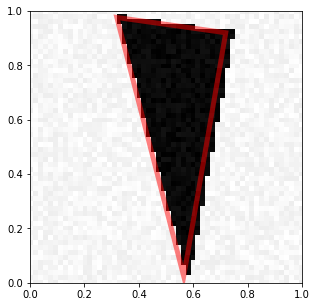

In [21]:
[X_train, Y_train] = generate_dataset_regression(300, 20)
visualize_prediction(X_train[0], Y_train[0])

In [22]:
print(Y_train.shape)

(300, 6)


## Normalization of the Data: 
### We want to normalize the Y data: we will sort our points by their abscissa.

In [23]:
def normalize(Y):
    number_sample = Y.shape[0]
    Y_res = np.zeros((number_sample, 6))
    print('Yshape', Y.shape)
    for i in range(number_sample):
        print(i)
        y_label = Y[i, ::]
        matrix_of_points = np.zeros((3,2))
        for j in range(3):
            px = y_label[2* j]
            py = y_label[2 * j + 1]
            matrix_of_points[j,0] = px
            matrix_of_points[j,1] = py
        #sorted on the vertices
        sorted_abscisses_matrix = np.argsort(matrix_of_points[::,0], axis = 0)
        for k in range(3):
            Y_res[i, 2*k] = matrix_of_points[sorted_abscisses_matrix[k], 0]
            Y_res[i, 2*k + 1] = matrix_of_points[sorted_abscisses_matrix[k], 1]
   

            
    return Y_res

Creating data:
0


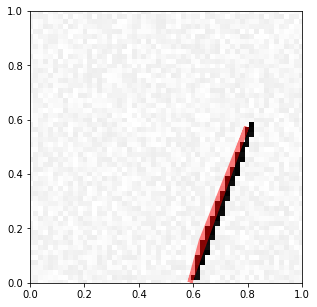

[[0.79666759 0.57383061 0.58829493 0.00179379 0.62989574 0.15513408]
 [0.09702915 0.83129408 0.14800154 0.87525047 0.11572229 0.84224569]]
Yshape (2, 6)
0
1


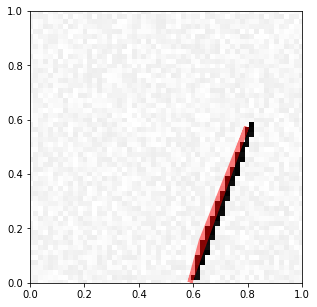

In [24]:
[X_train, Y_train] = generate_dataset_regression(2, 20)
#Y_train = normalize(Y_train)
visualize_prediction(X_train[0], Y_train[0])
print(Y_train)
Y_test = normalize(Y_train)
visualize_prediction(X_train[0], Y_test[0])

## The CNN model:
Here I used 4 four convutional layers, with a pooling layer between each of them, then I use two fully connected layers with activation "relu", then a final layer with sofmax activation. We will train on 2000 instances with 30 epochs.

In [25]:
model = Sequential()
model.add(Conv2D(16, (5, 5), activation='relu',
input_shape= (72, 72 , 1)))
model.add(Conv2D(16, (5,5), activation="relu", input_shape = (34,34,16)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (5,5), activation="relu", input_shape = (30,30,16)))
#print(model.output_shape)
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (5,5), activation="relu", input_shape = (28,28,32)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

In [26]:
adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad= False)
model.compile(loss='mean_squared_error',
optimizer = adam, metrics = ["accuracy"])
number_samples = 2000
[X_real, Y_train] = generate_dataset_regression(number_samples, 20)
X_train = np.zeros((number_samples,72,72))
for i in range(number_samples):
    x_sample = X_real[i]
    x_good = x_sample.reshape((72,72))
    X_train[i] = x_good
X_train = X_train.reshape(X_train.shape[0], 72, 72, 1)
X_train = X_train.astype('float32')
print(np.shape(X_train))
print(np.shape(Y_train))
Y_train = normalize(Y_train)
print(np.shape(Y_train))
model.fit(X_train, Y_train, epochs= 30, batch_size=32)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
(2000, 72, 72, 1)
(2000, 6)
Yshape (2000, 6)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
2

1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914


In [27]:
[X_real_test, Y_test] = generate_test_set_regression()
X_test = np.zeros((X_real_test.shape[0],72,72))
for i in range(X_real_test.shape[0]):
    x_sample = X_real_test[i]
    x_good = x_sample.reshape((72,72))
    X_test[i] = x_good
X_test = X_test.reshape(X_test.shape[0], 72, 72, 1)
X_test = X_test.astype('float32')
Y_test = normalize(Y_test)
print(np.shape(X_test))
print(np.shape(Y_test))
score = model.evaluate(X_test, Y_test)
Y_res = model.predict(X_test)
print("loss and accuracy of linear model with adam optimizer on test", score)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Yshape (300, 6)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
24

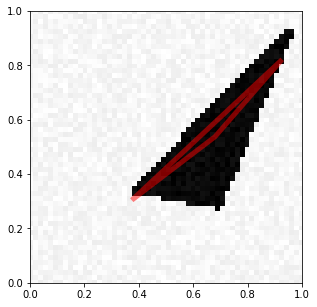

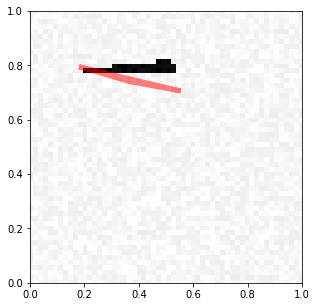

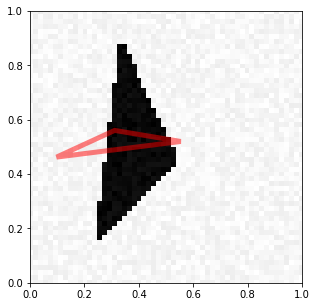

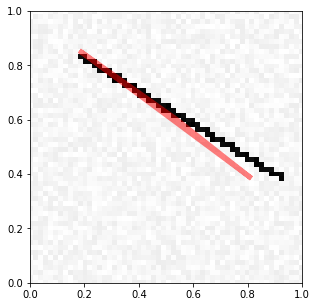

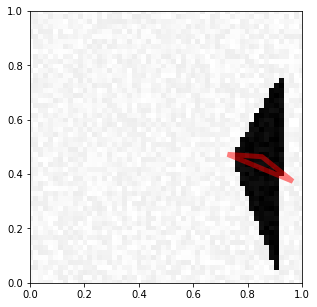

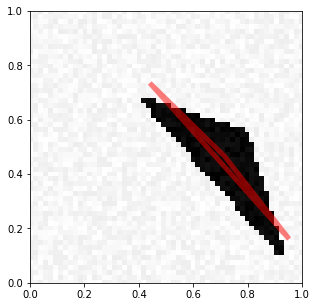

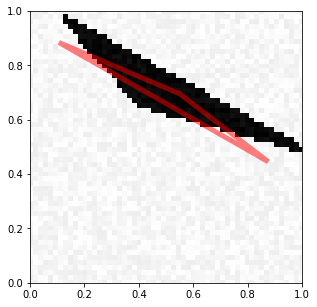

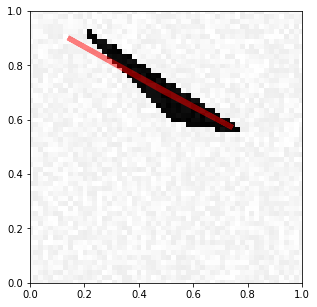

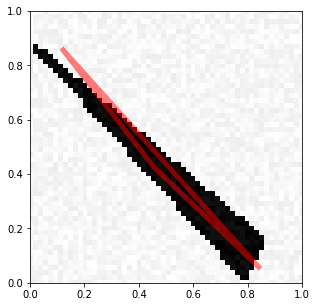

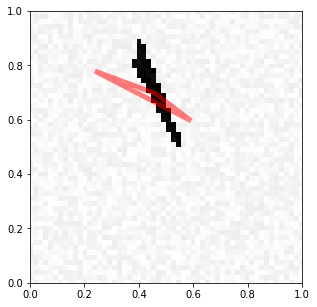

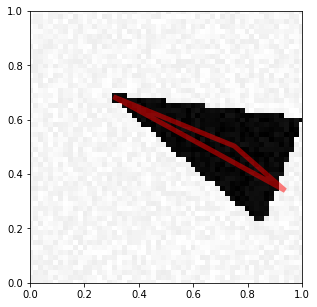

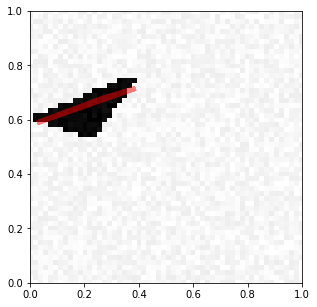

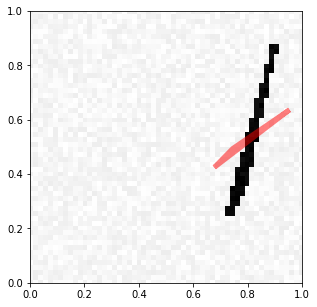

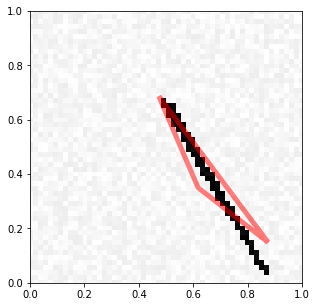

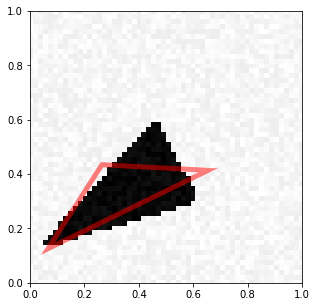

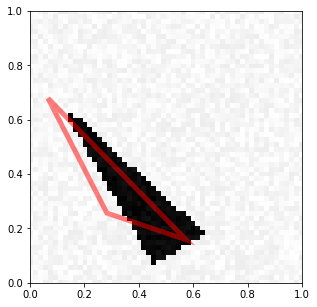

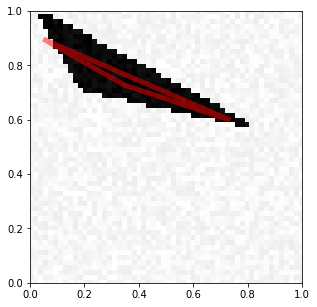

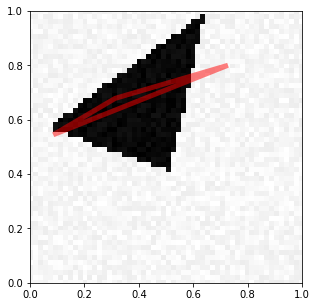

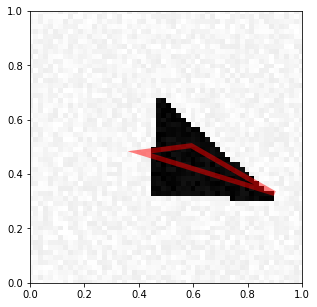

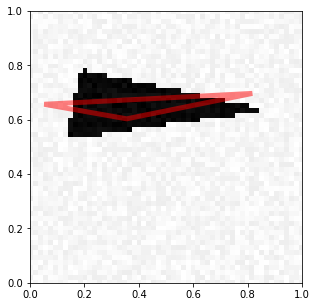

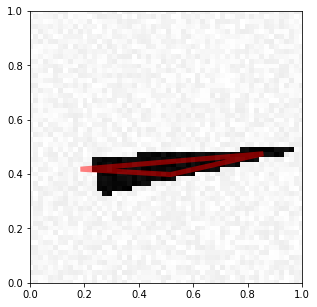

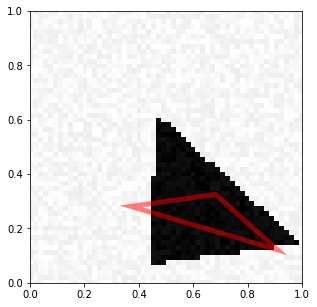

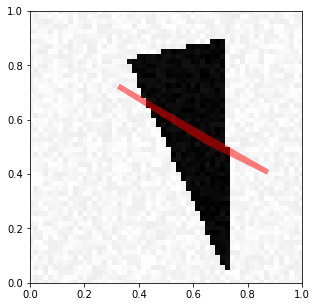

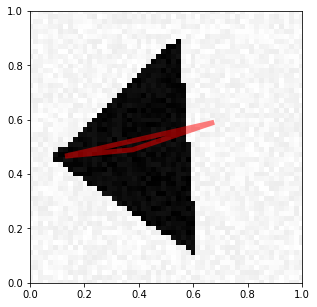

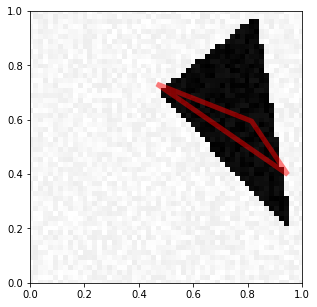

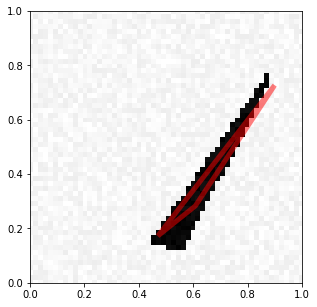

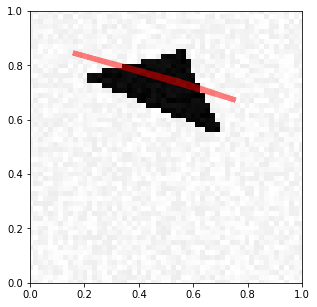

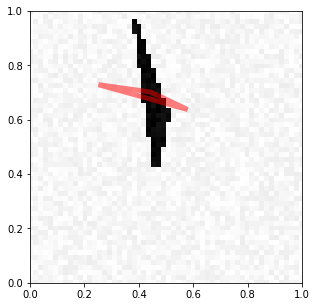

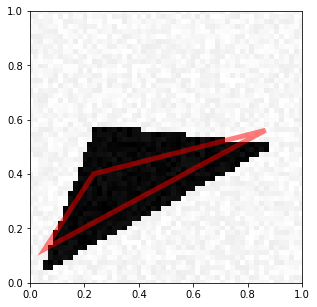

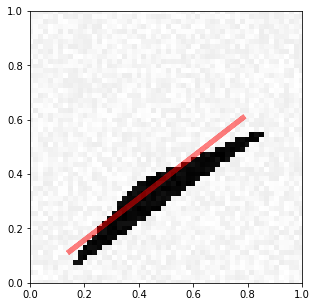

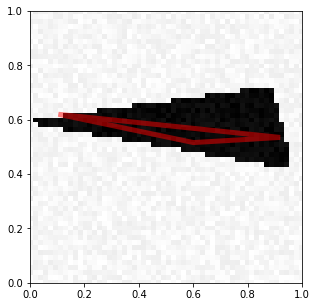

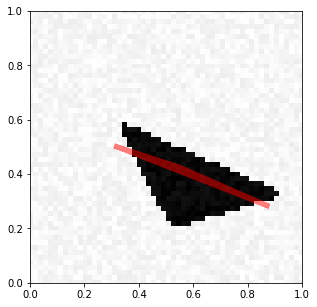

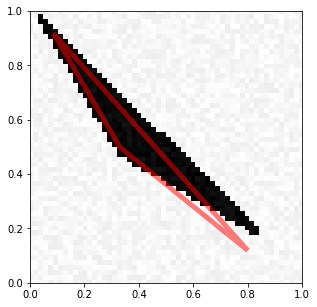

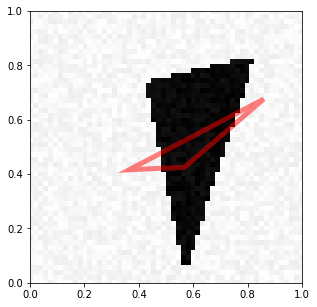

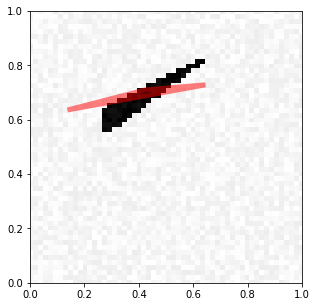

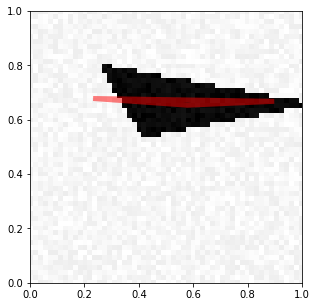

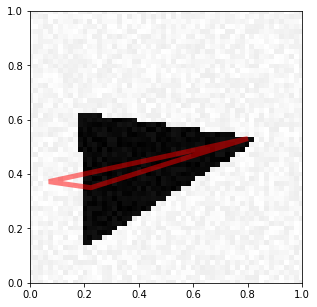

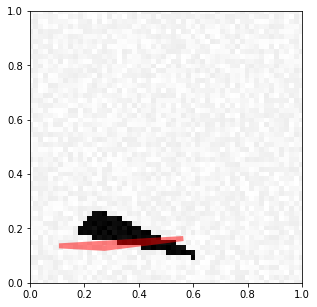

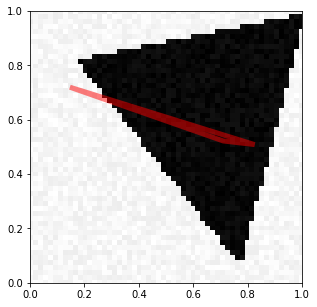

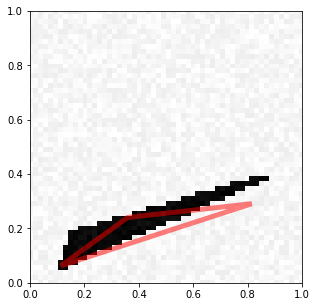

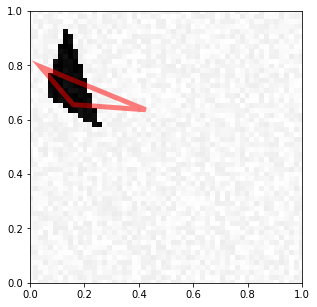

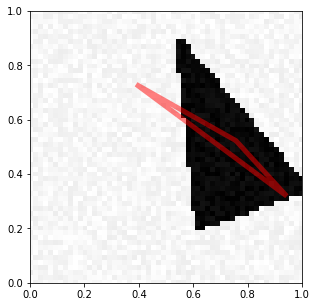

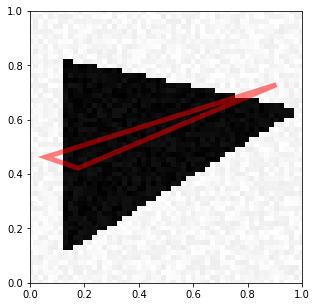

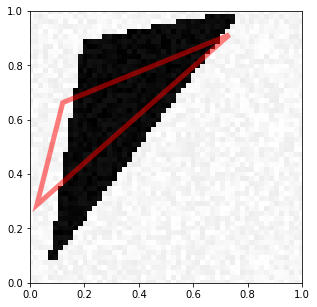

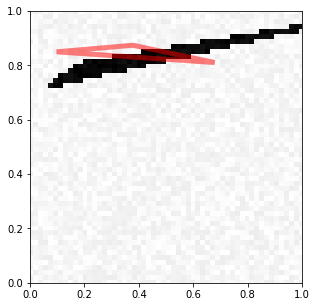

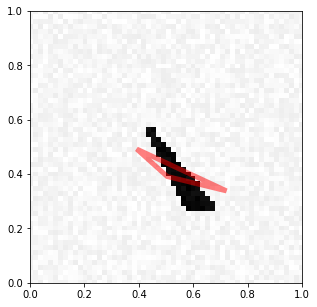

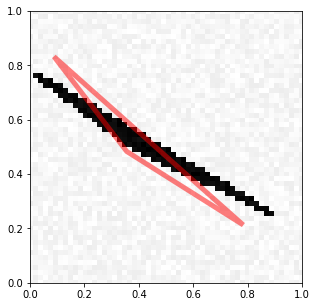

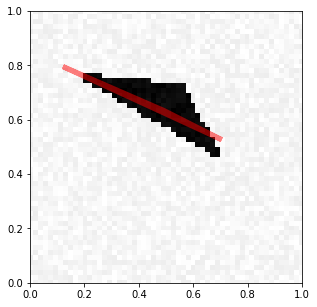

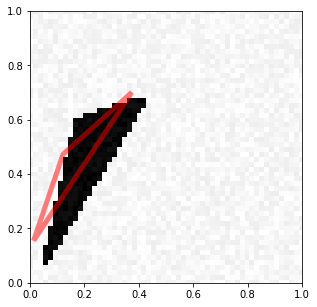

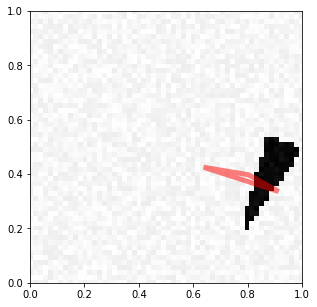

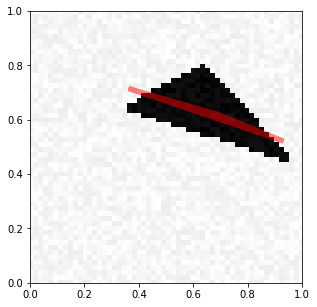

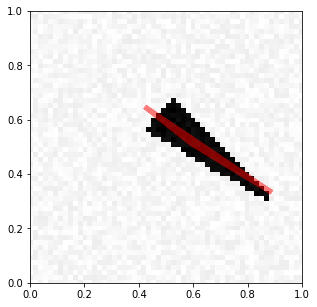

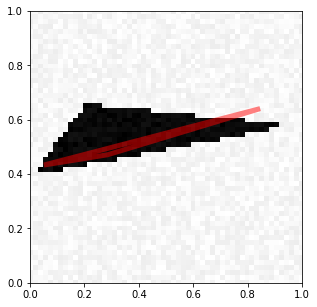

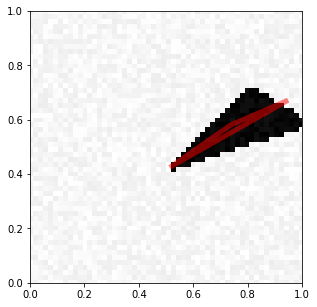

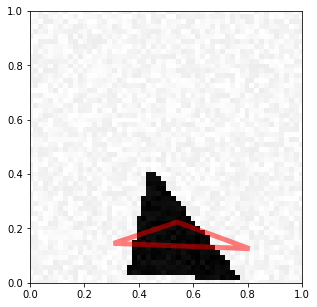

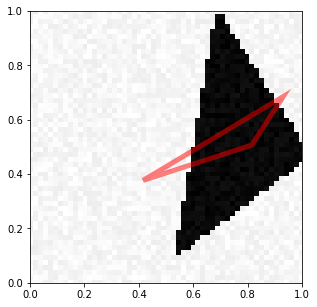

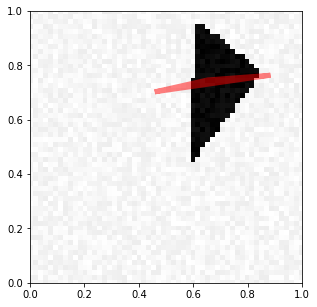

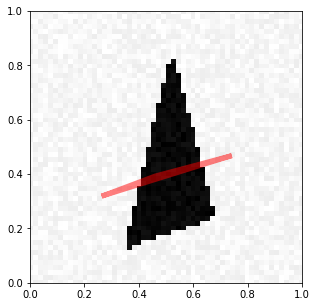

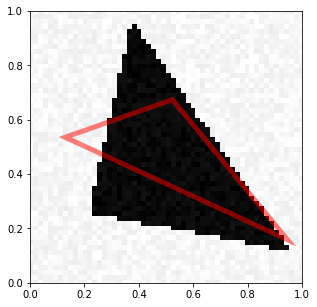

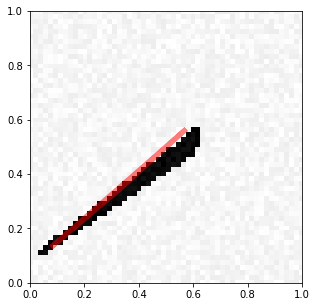

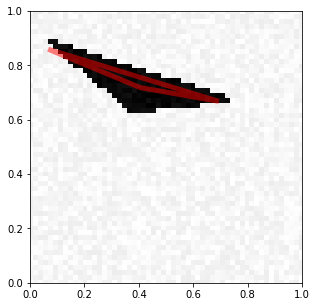

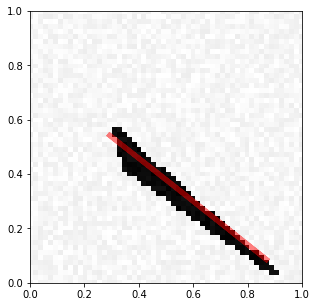

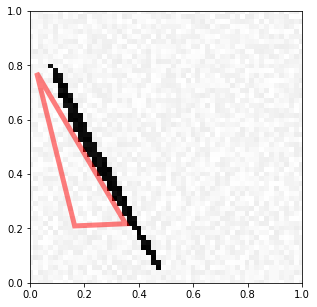

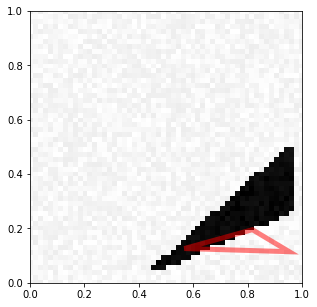

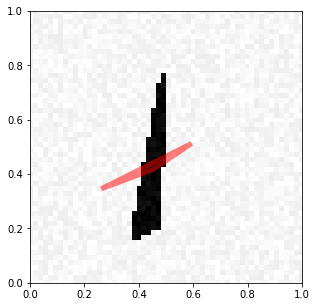

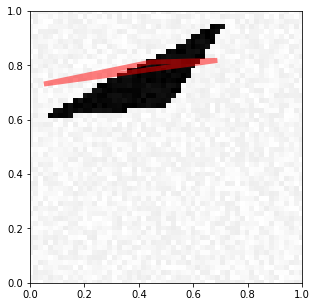

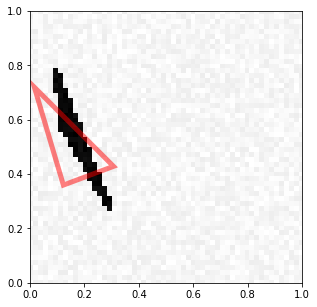

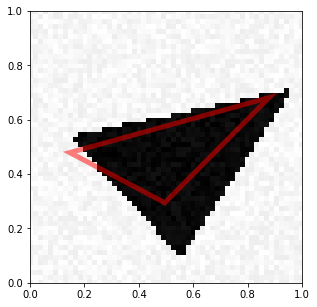

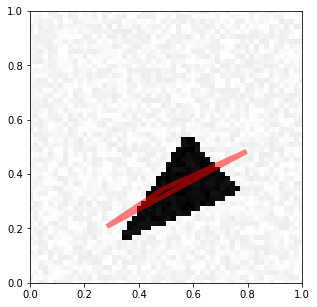

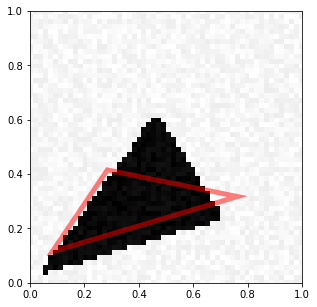

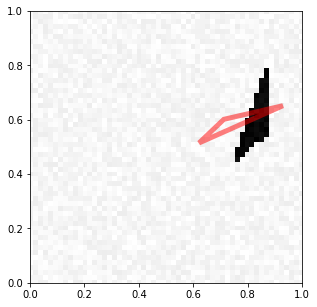

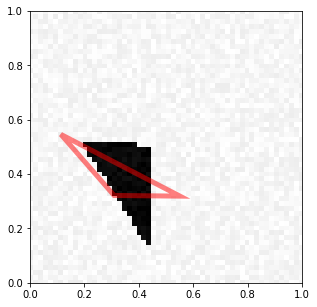

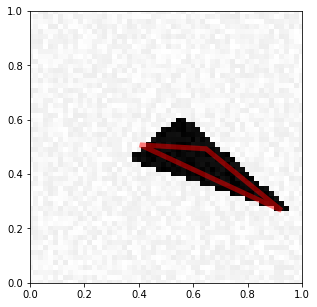

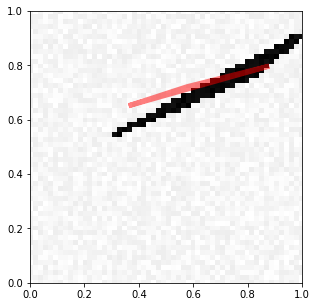

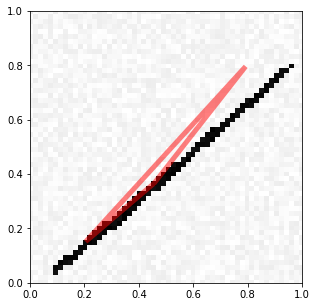

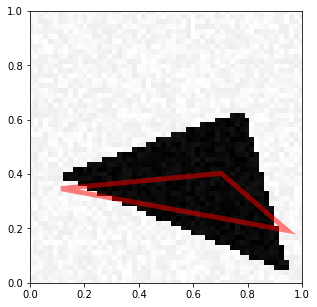

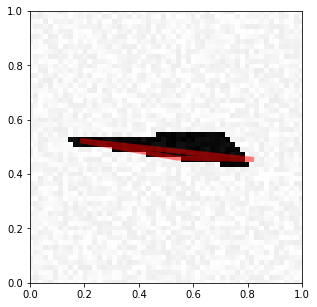

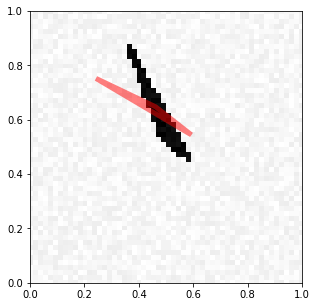

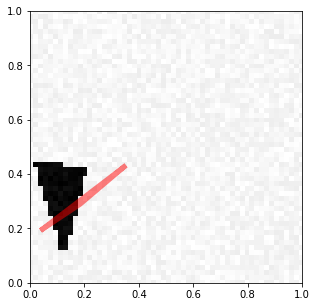

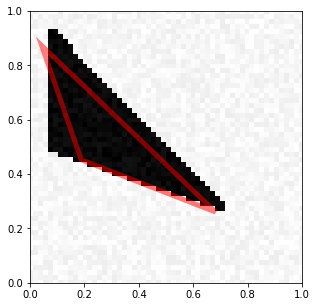

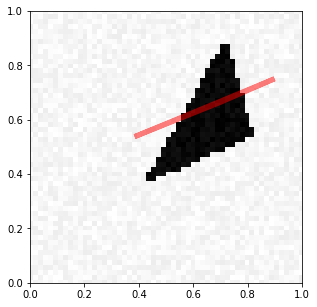

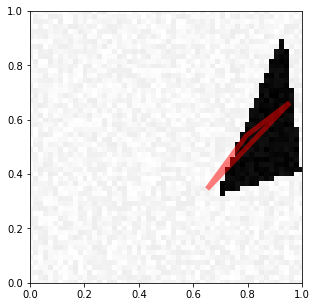

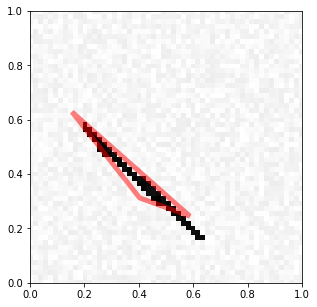

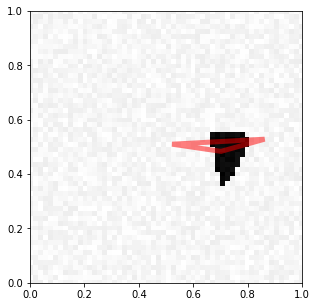

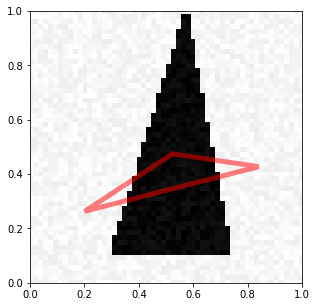

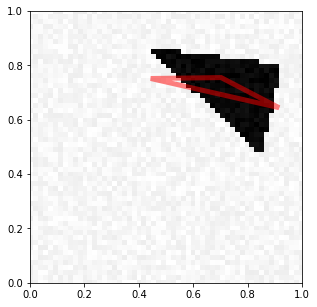

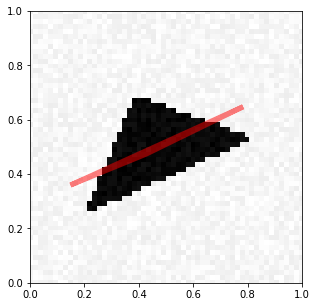

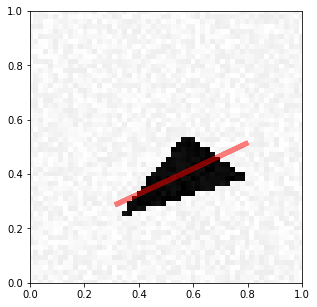

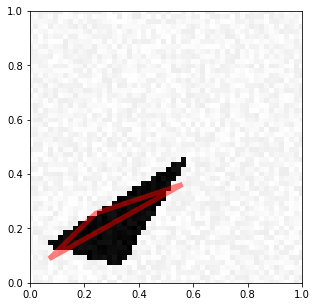

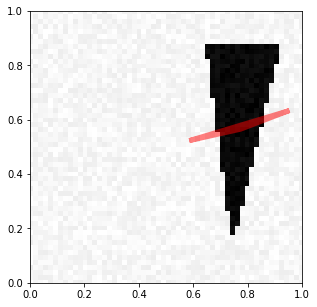

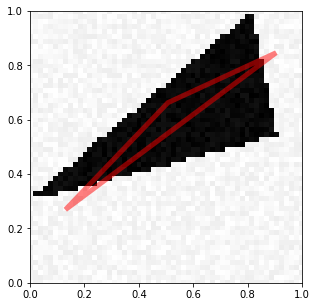

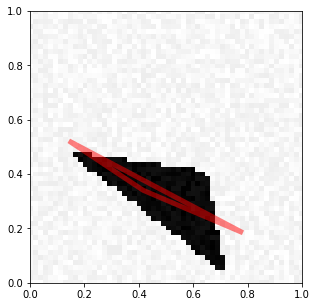

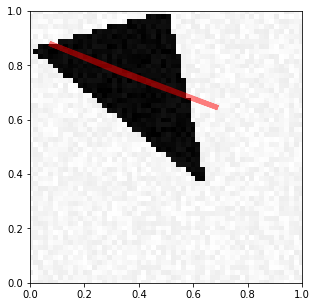

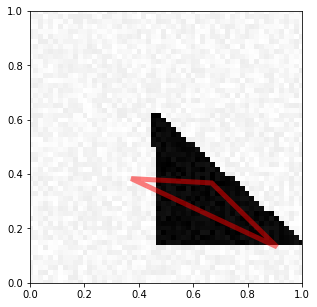

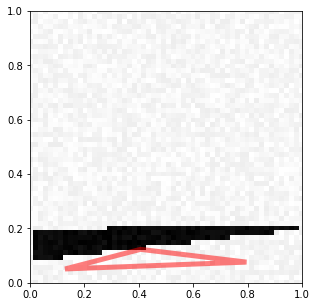

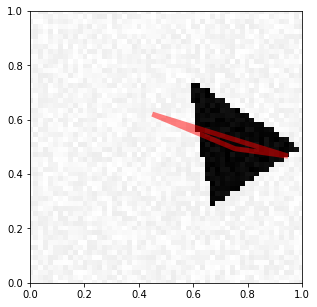

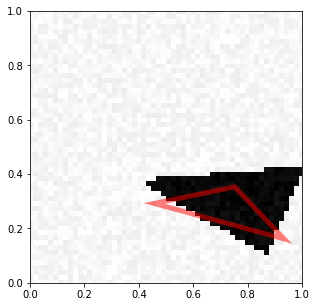

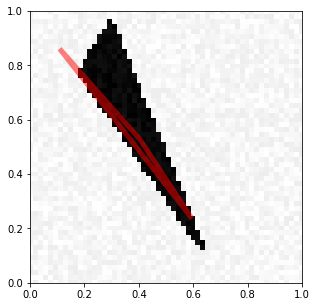

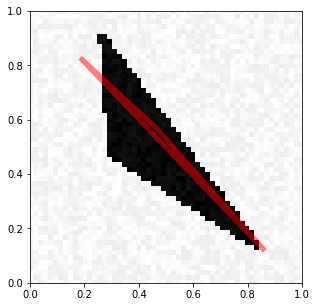

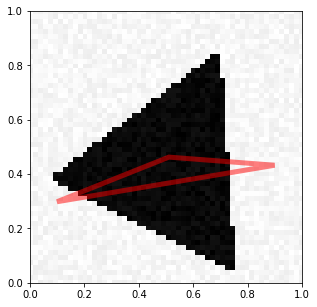

In [33]:
for i in range(100):
    visualize_prediction(X_test[i], Y_res[i])

## Observations and results
#### Here, we have the following results : 0.0199 of loss in training,  0.020 on test. 
#### As we can see in the above cell, the results are quite disappointing: Maybe using more instances and more epochs would improve  the solution

## Question 7) :
#### Unfortunately I could not be able to finish the homework, I put here the modified generation functions.

In [30]:
#modifying the functions to generate a pair good 
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    im_perfect = generate_a_drawing(figsize, U, V, 0)
    im_noised = generate_a_drawing(figsize, U, V, noise)
    return [im_noised, im_perfect]


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
        
    im_perfect = generate_a_drawing(figsize, U, V, 0)
    im_noised = generate_a_drawing(figsize, U, V, noise)
    return [im_noised, im_perfect]

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    im_perfect = generate_a_drawing(figsize, U, V, 0)
    im_noised = generate_a_drawing(figsize, U, V, noise)
    return [[imd_noised, im_perfect], [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_data_question_7(number_sample = 300, noise = 1.0):
    X = np.zeros([nb_samples,72,72])
    Y = np.zeros([nb_samples, 72, 72])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            [im_noised, im_perfect] = generate_a_rectangle(noise, free_location)
            X[i] = im_noised
            Y[i] = im_perfect
        elif category == 1: 
            [im_noised, im_perfect] = generate_a_disk(noise, free_location)
            [im_noised, im_perfect] = generate_a_rectangle(noise, free_location)
            X[i] = im_noised
            Y[i] = im_perfect
        else:
            [imd_noised, im_perfect] = generate_a_triangle(noise, free_location)[0]
            X[i] = im_noised
            Y[i] = im_perfect
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]
    
    